In [36]:
!pip install torchtuples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
import torchtuples as tt
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper 
%matplotlib inline 

In [38]:
!pip install pycox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import pycox
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [40]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [41]:
X_full = pd.read_csv('/content/METABRIC_RNA_Mutation.csv', low_memory=False)

In [42]:
clinical_df = X_full.iloc[:, :31]

In [43]:
clinical_df_inverted = clinical_df.copy()

In [44]:
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])

In [45]:
KM_df = clinical_df_inverted.copy()

In [46]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code', 'death_from_cancer'], axis=1, inplace=True)

In [47]:
cat_columns = [cname for cname in KM_df.columns if
                    KM_df[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype']


In [48]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [50]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(KM_df)
X_pandas

,cat__type_of_breast_surgery,cat__cancer_type_detailed,cat__cellularity,cat__pam50_+_claudin-low_subtype,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,...,remainder__neoplasm_histologic_grade,remainder__hormone_therapy,remainder__lymph_nodes_examined_positive,remainder__mutation_count,remainder__nottingham_prognostic_index,remainder__overall_survival_months,remainder__overall_survival,remainder__radio_therapy,remainder__tumor_size,remainder__tumor_stage
0,1.0,1.0,NaN,6.0,1.0,1.0,2.0,0.0,0.0,0.0,...,3.0,1,10.0,NaN,6.044,140.500000,0,1,22.0,2.0
1,0.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,...,3.0,1,0.0,2.0,4.020,84.633333,0,1,10.0,1.0
2,1.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,...,2.0,1,1.0,2.0,4.030,163.700000,1,0,15.0,2.0
3,1.0,4.0,2.0,3.0,1.0,1.0,2.0,0.0,4.0,1.0,...,2.0,1,3.0,1.0,4.050,164.933333,0,1,25.0,2.0
4,1.0,4.0,0.0,3.0,1.0,1.0,2.0,0.0,4.0,0.0,...,3.0,1,8.0,2.0,6.080,41.366667,1,1,40.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,0.0,2.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,...,3.0,1,1.0,4.0,5.050,196.866667,0,1,25.0,NaN
1900,1.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,...,3.0,0,1.0,6.0,5.040,44.733333,1,1,20.0,NaN
1901,1.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,3.0,1,45.0,4.0,6.050,175.966667,1,1,25.0,NaN
1902,1.0,1.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,2.0,1,12.0,15.0,5.050,86.233333,1,0,25.0,NaN


In [51]:
df_train = X_pandas
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [52]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [53]:
num_columns = [cname for cname in X_pandas.columns if 
                X_pandas[cname].dtype in ['int64', 'float64']]
print(num_columns)

['cat__type_of_breast_surgery', 'cat__cancer_type_detailed', 'cat__cellularity', 'cat__pam50_+_claudin-low_subtype', 'cat__er_status_measured_by_ihc', 'cat__er_status', 'cat__her2_status_measured_by_snp6', 'cat__her2_status', 'cat__tumor_other_histologic_subtype', 'cat__inferred_menopausal_state', 'cat__integrative_cluster', 'cat__primary_tumor_laterality', 'cat__pr_status', 'cat__3-gene_classifier_subtype', 'remainder__age_at_diagnosis', 'remainder__chemotherapy', 'remainder__neoplasm_histologic_grade', 'remainder__hormone_therapy', 'remainder__lymph_nodes_examined_positive', 'remainder__mutation_count', 'remainder__nottingham_prognostic_index', 'remainder__overall_survival_months', 'remainder__overall_survival', 'remainder__radio_therapy', 'remainder__tumor_size', 'remainder__tumor_stage']


In [79]:
cols_standardize = ['cat__cancer_type_detailed', 'cat__integrative_cluster', 'cat__primary_tumor_laterality', 'cat__pr_status', 'cat__3-gene_classifier_subtype', 'cat__cellularity', 'cat__her2_status_measured_by_snp6', 'cat__her2_status', 'cat__tumor_other_histologic_subtype','cat__pam50_+_claudin-low_subtype','remainder__age_at_diagnosis', 'remainder__neoplasm_histologic_grade', 'remainder__lymph_nodes_examined_positive', 'remainder__mutation_count', 'remainder__nottingham_prognostic_index', 'remainder__tumor_size', 'remainder__tumor_stage']
cols_leave = ['remainder__chemotherapy', 'remainder__hormone_therapy', 'remainder__overall_survival_months', 'remainder__overall_survival', 'remainder__radio_therapy']
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

In [80]:
df_train = X_pandas
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [81]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [82]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda X_pandas: (X_pandas['remainder__overall_survival_months'].values, X_pandas['remainder__overall_survival'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
months_test, events_test = get_target(df_test)

In [83]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [84]:
labtrans.cuts

array([  0.        ,  39.46666667,  78.93333333, 118.4       ,
       157.86666667, 197.33333333, 236.8       , 276.26666667,
       315.73333333, 355.2       ])

In [85]:
labtrans.cuts[y_train[0]]

array([118.4       , 197.33333333, 118.4       , ..., 118.4       ,
       157.86666667, 197.33333333])

#Нейронная сеть 2 скрытых слоя по 32 каждый, ReLU активац ф-я, and out_features output nodes. We also have batch normalization and dropout between the layers.

In [86]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [87]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [88]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [89]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.5072,	val_loss: 1.8735
1:	[0s / 0s],		train_loss: 1.8469,	val_loss: 1.9527
2:	[0s / 0s],		train_loss: 1.4869,	val_loss: 1.9838
3:	[0s / 0s],		train_loss: 1.2253,	val_loss: 1.5884
4:	[0s / 0s],		train_loss: 0.9504,	val_loss: 1.1226
5:	[0s / 0s],		train_loss: 0.7116,	val_loss: 0.7598
6:	[0s / 0s],		train_loss: 0.5757,	val_loss: 0.5312
7:	[0s / 0s],		train_loss: 0.4770,	val_loss: 0.4476
8:	[0s / 0s],		train_loss: 0.4182,	val_loss: 0.4103
9:	[0s / 0s],		train_loss: 0.3556,	val_loss: 0.3694
10:	[0s / 0s],		train_loss: 0.3323,	val_loss: 0.3943
11:	[0s / 0s],		train_loss: 0.2926,	val_loss: 0.5158
12:	[0s / 0s],		train_loss: 0.3075,	val_loss: 0.5536
13:	[0s / 0s],		train_loss: 0.2835,	val_loss: 0.5349
14:	[0s / 0s],		train_loss: 0.2578,	val_loss: 0.7980
15:	[0s / 0s],		train_loss: 0.2744,	val_loss: 0.3342
16:	[0s / 0s],		train_loss: 0.2698,	val_loss: 0.3186
17:	[0s / 0s],		train_loss: 0.2707,	val_loss: 0.2112
18:	[0s / 0s],		train_loss: 0.2347,	val_loss: 0.2406
19:

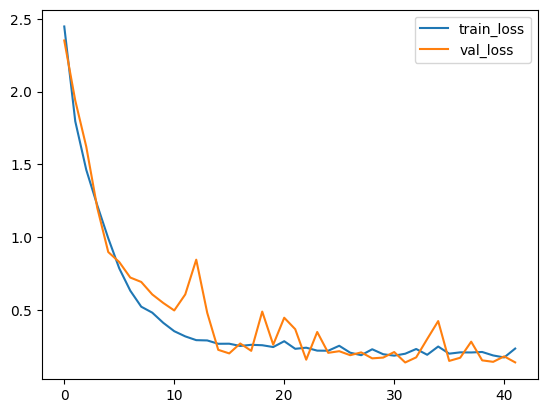

In [72]:
_ = log.plot()

In [90]:
log.to_pandas().val_loss.min()

0.15583811700344086

In [91]:
model.score_in_batches(val)

{'loss': 0.15583811700344086}

In [92]:
#предсказываем
surv = model.predict_surv_df(x_test)

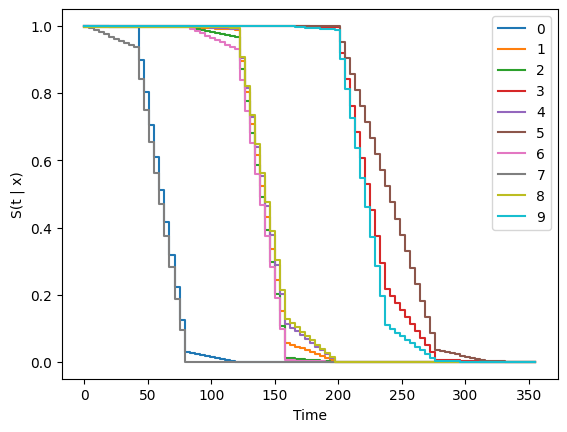

In [105]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [106]:
surv = model.interpolate(10).predict_surv_df(x_test)

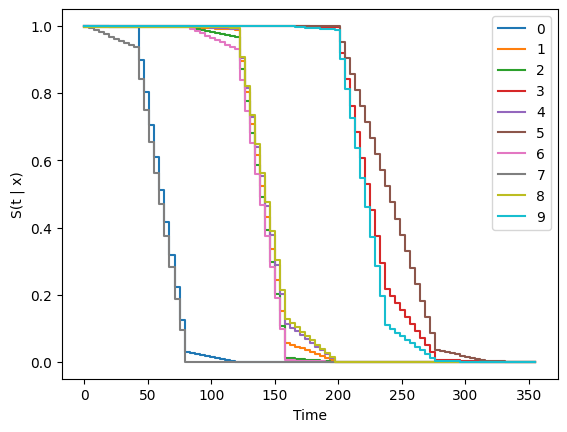

In [107]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [108]:
ev = EvalSurv(surv, months_test, events_test, censor_surv='km')

/usr/local/lib/python3.9/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [109]:
ev.concordance_td('antolini')

0.9886932488065096

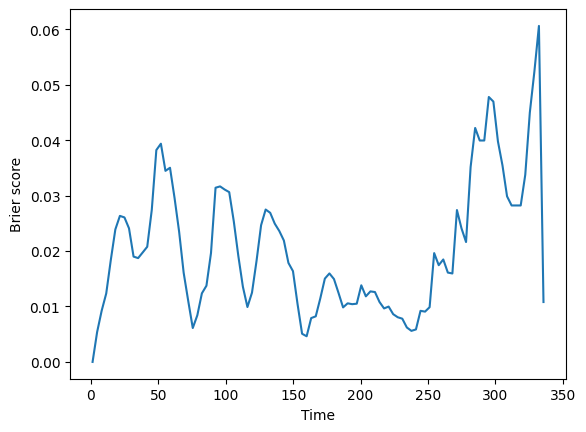

In [110]:
time_grid = np.linspace(months_test.min(), months_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

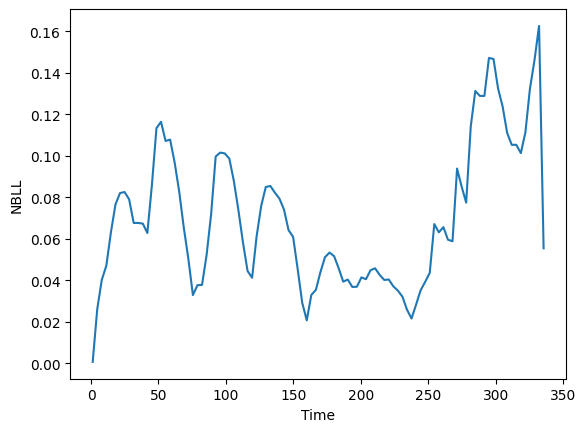

In [111]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [112]:
ev.integrated_brier_score(time_grid) 

0.02070240171631301

In [113]:
ev.integrated_nbll(time_grid) 

0.07063138087670702